# 5 Chemistry
The aim of this exercise is to understand how chemical networks work, to play with a network that describes the formation of water, and then to extend it to include also carbon monoxide.

The Python procedures provided integrate a reduced chemical network for $H_2 O$ for a period of $10^7$ yr. At its core is an ODE solver (`solve_ivp` from `scipy.integrate`) that evolves the system for a given time step (`time_step`) and initial conditions (`number_density`). The initial conditions are $n_{H_2} = 10^7$ cm$^{−3}$ and $n_O=10^4$ cm$^{−3}$ . We are assuming a partially molecular gas and a reservoir of $H_2$ which is only aﬀected by this network. All other species are initially set to a default minimum value of $10^{−40}$ cm$^{−3}$. The temperature is set to 50 K and remains constant since processes like cooling and heating are not included.

Three functions do the work: (i) the main one, `differential_equations()`, returns an array $d n_i/dt$ of size $N_s$ (`N_species`), which represents the system of ODEs. This function requires the (ii) `reaction rates()` function, which returns $N_r$ rates, using rate coefficients are provided by (iii) the function `rate_coefficients()`. 

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as tm

# Use scipy package solve_ivp to integrate the chemical network
from scipy.integrate import solve_ivp

### Dictionary mapping element names to indices

In [2]:
i = {'O+':0,'H2':1 ,'OH+':2, 'H':3, 'H2O+':4 , 'H3O+':5, 'E':6, 'H2O':7 , 'OH':8, 'O':9}
N_species = len(i)

### Initial values

In [3]:
number_density = np.zeros(N_species)
n_H2 = 1e7
number_density[:      ] = 1e-40
number_density[i['H2']] = n_H2
number_density[i['O' ]] = 1e-3*n_H2
Tgas = 50.0                             # Temperature [K], passed as global value
ionizing_cosmic_ray_flux = 1.3e-17      # Ionisation rate per atom [1/s]

### Reaction rate coefficients
We use a Python dictionary to name the rate coefficient as a string corresponding to the actual reaction. This autodocuments the network

In [4]:
def rate_coefficients():
    invsqrt = 1e0/np.sqrt(Tgas/3e2)
    k = {}
    k['O+   + H2 -> OH+  + H' ] = 1.6e-9
    k['OH+  + H2 -> H2O+ + H' ] = 1.1e-9
    k['H2O+ + H2 -> H3O+ + H' ] = 6.1e-10 
    k['H3O+ + E  -> H2O  + H' ] = 1.1e-7*invsqrt 
    k['H2O+ + E  -> OH   + H' ] = 8.6e-8*invsqrt
    k['H2O+ + E  -> O    + H2'] = 3.9e-8*invsqrt
    k['OH+  + E  -> O    + H' ] = 6.3e-9*(Tgas/3e2)**(-.48)
    k['O    + CR -> O+   + E' ] = 2.8e0*ionizing_cosmic_ray_flux
    return k
k=rate_coefficients()
k

{'O+   + H2 -> OH+  + H': 1.6e-09,
 'OH+  + H2 -> H2O+ + H': 1.1e-09,
 'H2O+ + H2 -> H3O+ + H': 6.1e-10,
 'H3O+ + E  -> H2O  + H': 2.694438717061496e-07,
 'H2O+ + E  -> OH   + H': 2.106561178793533e-07,
 'H2O+ + E  -> O    + H2': 9.553009996854394e-08,
 'OH+  + E  -> O    + H': 1.4888575570590416e-08,
 'O    + CR -> O+   + E': 3.64e-17}

In [5]:
print('We have',len(k),'rate coefficients')

We have 8 rate coefficients


### Reaction rates
The individual reaction rates can now easily be calculated

In [7]:
def reaction_rates(n):
    k = rate_coefficients()
    return  [k['O+   + H2 -> OH+  + H' ] * n[i['O+'  ]] * n[i['H2']], # 0
             k['OH+  + H2 -> H2O+ + H' ] * n[i['OH+' ]] * n[i['H2']], # 1
             k['H2O+ + H2 -> H3O+ + H' ] * n[i['H2O+']] * n[i['H2']], # 2
             k['H3O+ + E  -> H2O  + H' ] * n[i['H3O+']] * n[i['E' ]], # 3
             k['H2O+ + E  -> OH   + H' ] * n[i['H2O+']] * n[i['E' ]], # 4
             k['H2O+ + E  -> O    + H2'] * n[i['H2O+']] * n[i['E' ]], # 5
             k['OH+  + E  -> O    + H' ] * n[i['OH+' ]] * n[i['E' ]], # 6
             k['O    + CR -> O+   + E' ] * n[i['O'   ]]]              # 7
reaction_rates(number_density)

[1.6e-42,
 1.0999999999999997e-42,
 6.0999999999999996e-43,
 2.694438717061495e-87,
 2.1065611787935326e-87,
 9.553009996854392e-88,
 1.4888575570590414e-88,
 3.6399999999999996e-13]

### Differential equations
Given the above set of reaction rates, we can construct our differential equations for each species by inspection. Triple check when adding new; it is very easy to get wrong! Notice that for reactions where there are as many reactants as products, the lines have to sum to zero, while externally induced reactions by e.g. photos or CRs do not sum to zero.

In [8]:
def differential_equations(t,n):
    r = reaction_rates(n)
    dn = np.zeros(N_species)
    dn[i['O+'  ]] = -r[0]                              +r[7]
    dn[i['H2'  ]] = -r[0]-r[1]-r[2]          +r[5]
    dn[i['OH+' ]] = +r[0]-r[1]                    -r[6]
    dn[i['H'   ]] = +r[0]+r[1]+r[2]+r[3]+r[4]     +r[6]
    dn[i['H2O+']] =      +r[1]-r[2]     -r[4]-r[5]
    dn[i['H3O+']] =           +r[2]-r[3]
    dn[i['E'   ]] =                -r[3]-r[4]-r[5]-r[6]+r[7]
    dn[i['H2O' ]] =                +r[3]
    dn[i['OH'  ]] =                     +r[4]
    dn[i['O'   ]] =                          +r[5]+r[6]-r[7]
    return dn
differential_equations(0.0, number_density)

array([ 3.64000000e-13, -3.31000000e-42,  5.00000000e-43,  3.31000000e-42,
        4.90000000e-43,  6.10000000e-43,  3.64000000e-13,  2.69443872e-87,
        2.10656118e-87, -3.64000000e-13])

### Solution
To evolve these ordinary differential eqations (ODEs), we use the `solve_ivp` method from `scipy.integrate`.  Since we want to track the time evolution, we construct a time_grid with a timestep increasing by 5% each time (while avoiding to increase the time step to more than a million year since this tends to challenge the `solve_ivp` beyond what it can handle with the given network), and then call the solver.

*ramping up* the integration of the chemical network is standard practice. Often the initial condition will be far from equilibrium, and by slowly increasing the spacing between solution points we can catch reactions happening at different reaction velocities (e.g. it is related to the relative stiffness of the network).

Below we use a very low ```atol``` to make sure that even species with a number density of 1e-40 are properly tracked.

In [9]:
def solution(diff_eqs, yrs=1e7, max_step=1e6, method='LSODA', rtol=1e-6, atol=1e-40):
    spy = 365e0*24e0*3600e0        # seconds per year
    time_step = np.copy(spy)       # initial time-step (s)
    time_end  = yrs*spy            # end of simulation (s)
    n = number_density

    start = tm.time()

    # time_grid is a geometricly increasing series with a max spacing of "max_step" yrs
    time_grid = []
    time      = 0.1 * time_step   # initial time output > 0 to avoid species having 1e-40 number density
    while time < time_end:
        time_grid.append(time)
        time += time_step
        time_step = min(time_step * 1.05, max_step*spy)

    time_grid = np.array(time_grid)

    # Make sure we are charge neutral. Compute electrons number density (sum over ions)
    n[i['E']] = n[i['O+']] + n[i['OH+']] + n[i['H2O+']] + n[i['H3O+']]

    # Solve the differential equations defined in "diff_eqs" over the interval "(0,time_end)"
    # with input values "n" storing the solution at times "time_grid" using the ODE solver
    # method "method" (LSODA) with relative and absolute tolerances "rtol", "atol".
    solution = solve_ivp(diff_eqs, (0, time_end), n, t_eval=time_grid, \
                         method=method, rtol=rtol, atol=atol)
    print('time used: {:.2f} sec'.format(tm.time()-start))

    # return solution times in units of yr and number densities for each time in time_grid.
    return solution.t/spy, solution.y

yr,n = solution(differential_equations)

time used: 0.05 sec


### Plot results
Make a small routine that uses dictionary info to automatically plot all info about the species in the network as a function of time. To make the electron density (E) stand out, it is plotted with a dashed linetype.

time used: 0.03 sec


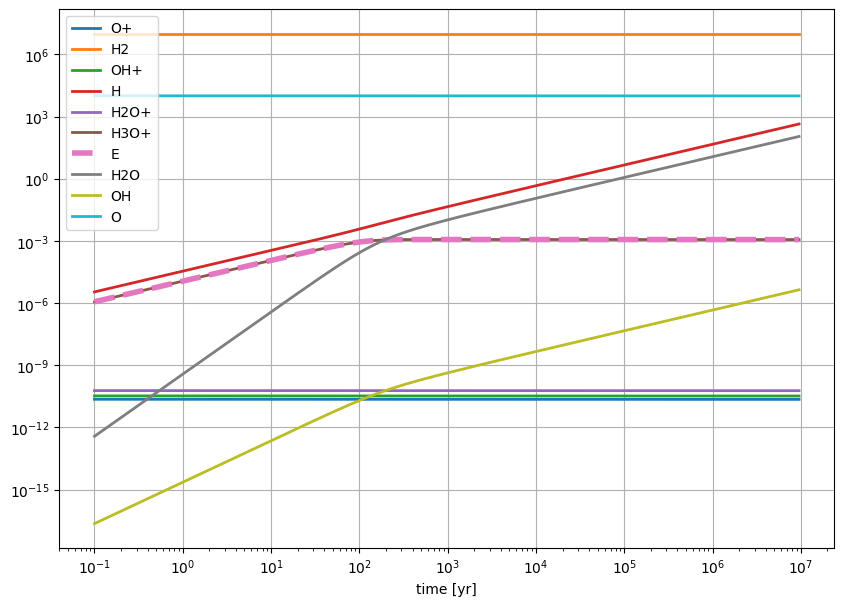

In [10]:
def plot(result,first=0,last=N_species,linewidth=2,mark=None):
    yr = result[0]
    n = result[1]
    names = list(i.keys())
    plt.figure(figsize=(10,7))
    plt.grid()
    #plt.ylim(ymin=10**2,ymax=10**5)
    for j in range(first,last):
        if names[j]=='E':
            plt.loglog(yr,n[j],'--',label=names[j],linewidth=linewidth*2)
        elif names[j]==mark:
            plt.loglog(yr,n[j],'-+',label=names[j],linewidth=linewidth)
        else:
            plt.loglog(yr,n[j],label=names[j],linewidth=linewidth)
    plt.xlabel('time [yr]')
    plt.legend();

# set cosmic ray flux and recalculate network
ionizing_cosmic_ray_flux = 1.3e-17
result = solution(differential_equations)
plot(result)

### Utilities for printing equations and reactions rates 
First a routine ```eqnh``` that constructs a header line. The next prodocedure, ```eqnp``` prints a line, with blanks for rates that are not relevant, and red/black for important / unimportant rates (10% is the limit used -- you can change it of course)

In [11]:
def eqnh(r):
    """ Print a rate eqn header """
    nr = len(r)
    s = '  Eqn:      sum = '
    for j in range(nr):
        space = '    ' if j<10 else '   '
        s += space+'r[{:d}]'.format(j)
    print(s)
    
def eqnp(label,select,dn,r):
    """ Print rates, with dominant ones in red """
    nr = len(r)
    red = '\x1b[31m'
    black = '\x1b[0m'
    rmax = 0.0
    for j in range(nr):
        if select[j] != 0:
            ra = np.abs(r[j])
            if ra > rmax:
                rmax = ra
    s = '{:>5}: {:8.1e} = '.format(label,dn[i[label]])
    for j in range(nr):
        ra = np.abs(r[j])
        color = red if ra > 0.1*rmax else black          
        if select[j]==0:
            s += '        '
        elif select[j]>0:
            s += '{}+{:7.1e}{}'.format(color,r[j],black)
        else:
            s += '{}-{:7.1e}{}'.format(color,r[j],black)
    print(s)

# for convenience, a small function to print out the network
def rpr(n):
    j = 0
    print('with the reaction rates:')
    for k in rate_coefficients().keys():
        s = 'r[{}]'.format(j)
        print('{:>22}: {}'.format(s,k))
        j += 1

This is where you arrange the actual printing, by entering 0 for rates that are not present, and +1 / -1 for positive and negative rates:

In [12]:
def print_rates(n,t=0.0):
    r = reaction_rates(n)
    eqnh(r)
    dn = np.zeros(N_species)           
    dn[i['O+'  ]] = -r[0]                              +r[7]
    eqnp('O+',    [ -1,   0,   0,   0,   0,   0,   0,  +1  ], dn, r)
    dn[i['H2'  ]] = -r[0]-r[1]-r[2]          +r[5] 
    eqnp('H2',    [ -1,  -1,  -1,   0,   0,  +1,   0,  0   ], dn, r)
    dn[i['OH+' ]] = +r[0] -r[1]                    -r[6]
    eqnp('OH+',   [ +1,  -1,   0,   0,   0,   0,  -1,  0   ], dn, r)
    dn[i['E'   ]] =                -r[3]-r[4]-r[5]-r[6]+r[7] 
    eqnp('E',     [  0,   0,   0,  -1,  -1,  -1,  -1,  +1  ], dn, r)
    dn[i['H'   ]] = +r[0]+r[1]+r[2]+r[3]+r[4]     +r[6] 
    eqnp('H',     [  1,   1,   1,  1,  1,  0,  +1,  0  ], dn, r)
    dn[i['H2O'   ]] =                +r[3] 
    eqnp('H2O',     [  0,   0,   0,  1, 0,  0,  0,  0  ], dn, r)
    dn[i['OH'   ]] =                +r[4] 
    eqnp('OH',     [  0,   0,   0,  0,  +1,  0,  0,  0 ], dn, r)
    dn[i['H2O+'   ]] =                 +r[1]-r[2]     -r[4]-r[5]
    eqnp('H2O+',     [  0,   +1,   -1,  0,  -1,  +1,  0,  0 ], dn, r)
    dn[i['O'   ]] =                 +r[5]+r[6]-r[7]
    eqnp('O',     [  0,   0,   0,  0,  0,  +1,  +1,  -1 ], dn, r)
    dn[i['H3O+'   ]] =      +r[2]-r[3]
    eqnp('H3O+',     [  0,   0,   1,  -1,  0,  0,  0,  0 ], dn, r)
    ### You can add more reactions here ###
    print('\nFILL IN THE REST OF THE NETWORK HERE!\n')
    rpr(n)

print_rates(n[:,-1])

  Eqn:      sum =     r[0]    r[1]    r[2]    r[3]    r[4]    r[5]    r[6]    r[7]
   O+: -3.3e-27 = -3.6e-13                                                +3.6e-13
   H2: -1.1e-12 = -3.6e-13-3.6e-13-3.6e-13                +6.5e-21                
  OH+: -1.3e-27 = +3.6e-13-3.6e-13                                -5.6e-22        
    E: -2.1e-20 =                         -3.6e-13-1.4e-20-6.5e-21-5.6e-22+3.6e-13
    H:  1.4e-12 = +3.6e-13+3.6e-13+3.6e-13+3.6e-13+1.4e-20        +5.6e-22        
  H2O:  3.6e-13 =                         +3.6e-13                                
   OH:  1.4e-20 =                                 +1.4e-20                        
 H2O+: -2.0e-27 =         +3.6e-13-3.6e-13        -1.4e-20+6.5e-21                
    O: -3.6e-13 =                                         +6.5e-21+5.6e-22-3.6e-13
 H3O+: -2.1e-20 =                 +3.6e-13-3.6e-13                                

FILL IN THE REST OF THE NETWORK HERE!

with the reaction rates:
                  r[0]

__HINT:__ Use the "Insert" button on your keyboard to switch from "insert" to "overwrite" (and back)!

#### __Task 2: Describe and discuss the evolution
   1. Some abundances change dramatically, while others (also some molecules) don't - why? 
   2. In particular, what is happening with hydrogen (H)?
   3. Some of the ones that change stop changing at some point in time - why? 

Discuss and explain, in terms of the reaction network and coefficients!  

#### __Task 3: Vary the cosmic ray flux
One of the reactions is controlled by the cosmic ray (CR) ﬂux. What happens when reducing it by one and then two orders of magnitude?  What is the role of oxygen ionization by cosmic rays in the network ?

time used: 0.03 sec


<Figure size 100x100 with 0 Axes>

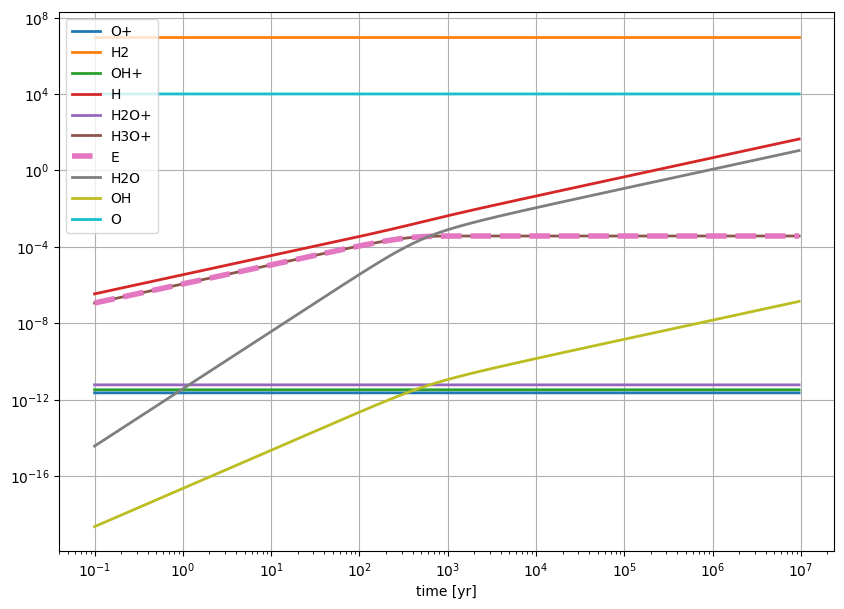

In [13]:
ionizing_cosmic_ray_flux = 1.3e-18
plt.figure(figsize=(1, 1))
plot(solution(differential_equations))

## Carbon monoxide (CO)
Carbon monoxide (CO) is arguably, next after H$_2$ and H$_2$O, the most important molecule in the interstellar medium and in protoplanetary disks, both because it affects the abundance of many other molecules, and because it is easily detected, and hence is often used as a proxy to estimate other abundances.   

CO is a strongly bound molecule, which under a broad range of conditions tends to consume most of the available carbon and / or oxygen. Under normal conditions there is more oxygen than carbon (about twice as much), and thus almost all of the carbon ends up in CO and CO consumes a corresponding amount of oxygen.  If, on the other hand, carbon is more abundant than oxygen (basically the definition of 'carbon stars'), then it's the other way around; nearly all oxygen gets locked up into CO. Carbon stars are generally the only place in the universe where refractory carbon (think _wood_) can be made in large quantities. Note that, since oxygen is a crucial element in many other reactions, the ratio C:O is thus a very important abundance parameter!

#### __Task 4: Add Carbon Monoxide (CO) to the reaction network
Your task here is to add species and reactions to the network relevant for CO, and discuss the behavior and influence of this important molecule. 

There are many reactions that influence the amount of CO, and many papers that use various simplified reaction networks. One of them, Nelson and Langer (1997), is available on Absalon as an annotated PDF file, and from that we may adopt these reactions and rates (simplified even somewhat relative to the paper):

To implement, you should
   1. Consider which extra species you need to add
   2. Add the reactions listed above to the coefficents and rates functions
   3. Add the extra equations needed to follow the evolution of the extra species, and add the new rates to these and to those existing equations that are also affected
   4. Optionally, fill in a scheme such as the one above, so you can see the importance of the different reaction channels

You can then discuss how CO behaves and influences the rest of the network. _Suggenstions_ for what to look at are

   5. How fast is CO formed; how does it change the oxygen reservoir, and what other species starts to dominate at the end of the evolution 
   6. How does the value of `tau_UV` affect the network (what is tau_UV; try changing it)? What about the initial mix of C and O?
   7. (Bonus task) What reactions are the bottlenecks for the creation of CO?

Notice that because we add C to the network, we need a new initial condition, and with a more complete network we can assume a lower and more realistic abundance for O. The following block of code is a *suggestion* and can be executed once you have defined an updated list of species

### Plot the results that correspond to the original case
HINT:  You can compare side-by-side, by right-clicking on the tab and choose "New view for Notebook"-

time used: 0.03 sec


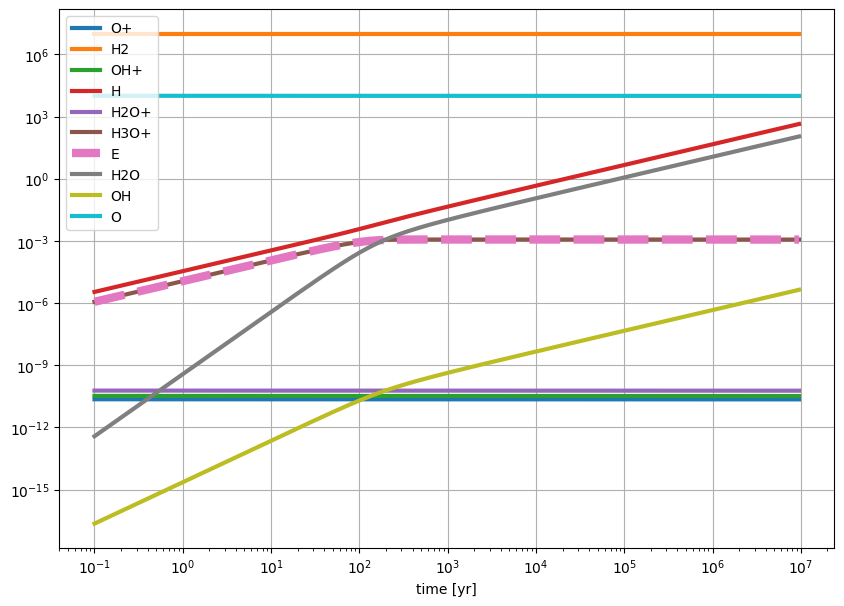

In [14]:
ionizing_cosmic_ray_flux = 1.3e-17
result = solution(differential_equations)
N_first = 10
plot(result,last=N_first,linewidth=3)

### Task 4

Add the elements that are needed to our network

In [17]:
i = {'O+':0,'H2':1 ,'OH+':2, 'H':3, 'H2O+':4 , 'H3O+':5, 'E':6, 'H2O':7 , 'OH':8, 'O':9,'CO':10,'hν':11 ,'C':12,'C+':13, 'CH2+':14 , 'CH2':15}
N_species = len(i)

Add the number density for the different species

In [18]:
number_density = np.zeros(N_species)
n_H2 = 1e7
Tgas = 50
number_density[:      ] = 1e-40
number_density[i['H2']] = n_H2
number_density[i['C' ]] = n_H2*1e-4
number_density[i['O' ]] = n_H2*2e-4

Add the rate coefficients. During the compose of the function above we used the variable $\tau_{UV}$. This variable is basically the optical depth of the UV radiation. The optical depth is defined as $\int\ k\cdot\rho\ dl$, where $k\cdot\rho$ is the opacity and $dl$ is the length that the ray goes through.

In [19]:
def rate_coefficient_new():
    invsqrt = 1e0/np.sqrt(Tgas/3e2)
    tau_UV=2 #1 or 2 e-11, 3 or 4 e-12, 5 or 6 e-13
    k = {}
    k['O+   + H2 -> OH+  + H' ] = 1.6e-9
    k['OH+  + H2 -> H2O+ + H' ] = 1.1e-9
    k['H2O+ + H2 -> H3O+ + H' ] = 6.1e-10 
    k['H3O+ + E  -> H2O  + H' ] = 1.1e-7*invsqrt 
    k['H2O+ + E  -> OH   + H' ] = 8.6e-8*invsqrt
    k['H2O+ + E  -> O    + H2'] = 3.9e-8*invsqrt
    k['OH+  + E  -> O    + H' ] = 6.3e-9*(Tgas/3e2)**(-.48)
    k['O    + CR -> O+   + E' ] = 2.8e0*ionizing_cosmic_ray_flux
    k['CO   + hv -> C    + O' ] = 1e-10*np.exp(-tau_UV)
    k['C    + hv -> C+   + E' ] = 1e-10*np.exp(-tau_UV)
    k['C+   + H2 -> CH2+ + hv'] = 5e-16
    k['CH2+ + E  -> CH2  + hv'] = 1.0e-8*invsqrt
    k['CH2  + hv -> C    + H2'] = 1e-10*np.exp(-tau_UV)
    k['CH2  + O  -> CO   + H2'] = 5e-10
    k['H    + CR -> H+   + E' ] = 2.8e0*ionizing_cosmic_ray_flux
    return k
k=rate_coefficient_new()
k

{'O+   + H2 -> OH+  + H': 1.6e-09,
 'OH+  + H2 -> H2O+ + H': 1.1e-09,
 'H2O+ + H2 -> H3O+ + H': 6.1e-10,
 'H3O+ + E  -> H2O  + H': 2.694438717061496e-07,
 'H2O+ + E  -> OH   + H': 2.106561178793533e-07,
 'H2O+ + E  -> O    + H2': 9.553009996854394e-08,
 'OH+  + E  -> O    + H': 1.4888575570590416e-08,
 'O    + CR -> O+   + E': 3.64e-17,
 'CO   + hv -> C    + O': 1.353352832366127e-11,
 'C    + hv -> C+   + E': 1.353352832366127e-11,
 'C+   + H2 -> CH2+ + hv': 5e-16,
 'CH2+ + E  -> CH2  + hv': 2.4494897427831778e-08,
 'CH2  + hv -> C    + H2': 1.353352832366127e-11,
 'CH2  + O  -> CO   + H2': 5e-10,
 'H    + CR -> H+   + E': 3.64e-17}

In [20]:
print('We have',len(k),'rate coefficients')

We have 15 rate coefficients


In [21]:
def reaction_rates(n):
    k = rate_coefficients()
    return  [k['O+   + H2 -> OH+  + H' ] * n[i['O+'  ]] * n[i['H2']], # 0
             k['OH+  + H2 -> H2O+ + H' ] * n[i['OH+' ]] * n[i['H2']], # 1
             k['H2O+ + H2 -> H3O+ + H' ] * n[i['H2O+']] * n[i['H2']], # 2
             k['H3O+ + E  -> H2O  + H' ] * n[i['H3O+']] * n[i['E' ]], # 3
             k['H2O+ + E  -> OH   + H' ] * n[i['H2O+']] * n[i['E' ]], # 4
             k['H2O+ + E  -> O    + H2'] * n[i['H2O+']] * n[i['E' ]], # 5
             k['OH+  + E  -> O    + H' ] * n[i['OH+' ]] * n[i['E' ]], # 6
             k['O    + CR -> O+   + E' ] * n[i['O'   ]]]              # 7
reaction_rates(number_density)

[1.6e-42,
 1.0999999999999997e-42,
 6.0999999999999996e-43,
 2.694438717061495e-87,
 2.1065611787935326e-87,
 9.553009996854392e-88,
 1.4888575570590414e-88,
 7.279999999999999e-14]